# MVA - Homework 1 - Reinforcement Learning (2021/2022)

**Name:** BRUTTI Rafaël

## Instructions

* The deadline is **November 12 at 11:59 pm (Paris time).**

* By doing this homework you agree to the late day policy, collaboration and misconduct rules reported on [Piazza](https://piazza.com/class/ktmvsc4knke4ia?cid=6).

* **Mysterious or unsupported answers will not receive full credit**. A correct answer, unsupported by calculations, explanation, or algebraic work will receive no credit; an incorrect answer supported by substantially correct calculations and explanations might still receive partial credit.

* Answers should be provided in **English**.

# Colab setup

In [1]:
from IPython import get_ipython

if 'google.colab' in str(get_ipython()):
  # install rlberry library
  !pip install git+https://github.com/rlberry-py/rlberry.git@mva2021#egg=rlberry[default] > /dev/null 2>&1

  # install ffmpeg-python for saving videos
  !pip install ffmpeg-python > /dev/null 2>&1

  # packages required to show video
  !pip install pyvirtualdisplay > /dev/null 2>&1
  !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

  print("Libraries installed, please restart the runtime!")


Libraries installed, please restart the runtime!


In [2]:
# Create directory for saving videos
!mkdir videos > /dev/null 2>&1

# Initialize display and import function to show videos
import rlberry.colab_utils.display_setup
from rlberry.colab_utils.display_setup import show_video

In [3]:
# Useful libraries
import numpy as np
import matplotlib.pyplot as plt

# Preparation

In the coding exercises, you will use a *grid-world* MDP, which is represented in Python using the interface provided by the [Gym](https://gym.openai.com/) library. The cells below show how to interact with this MDP and how to visualize it.


In [4]:
from rlberry.envs import GridWorld

def get_env():
  """Creates an instance of a grid-world MDP."""
  env = GridWorld(
      nrows=5,
      ncols=7,
      reward_at = {(0, 6):1.0},
      walls=((0, 4), (1, 4), (2, 4), (3, 4)),
      success_probability=0.9,
      terminal_states=((0, 6),)
  )
  return env

def render_policy(env, policy=None, horizon=50):
  """Visualize a policy in an environment

  Args:
    env: GridWorld
        environment where to run the policy
    policy: np.array
        matrix mapping states to action (Ns).
        If None, runs random policy.
    horizon: int
        maximum number of timesteps in the environment.
  """
  env.enable_rendering()
  state = env.reset()                       # get initial state
  for timestep in range(horizon):
      if policy is None:
        action = env.action_space.sample()  # take random actions
      else:
        action = policy[state]
      next_state, reward, is_terminal, info = env.step(action)
      state = next_state
      if is_terminal:
        break
  # save video and clear buffer
  env.save_video('./videos/gw.mp4', framerate=5)
  env.clear_render_buffer()
  env.disable_rendering()
  # show video
  show_video('./videos/gw.mp4')


[INFO] OpenGL_accelerate module loaded 
[INFO] Using accelerated ArrayDatatype 
[INFO] Generating grammar tables from /usr/lib/python3.7/lib2to3/Grammar.txt 
[INFO] Generating grammar tables from /usr/lib/python3.7/lib2to3/PatternGrammar.txt 


In [5]:
# Create an environment and visualize it
env = get_env()
render_policy(env)  # visualize random policy

# The reward function and transition probabilities can be accessed through
# the R and P attributes:
print(f"Shape of the reward array = (S, A) = {env.R.shape}")
print(f"Shape of the transition array = (S, A, S) = {env.P.shape}")
print(f"Reward at (s, a) = (1, 0): {env.R[1, 0]}")
print(f"Prob[s\'=2 | s=1, a=0]: {env.P[1, 0, 2]}")
print(f"Number of states and actions: {env.Ns}, {env.Na}")

# The states in the griworld correspond to (row, col) coordinates.
# The environment provides a mapping between (row, col) and the index of
# each state:
print(f"Index of state (1, 0): {env.coord2index[(1, 0)]}")
print(f"Coordinates of state 5: {env.index2coord[5]}")

Shape of the reward array = (S, A) = (31, 4)
Shape of the transition array = (S, A, S) = (31, 4, 31)
Reward at (s, a) = (1, 0): 0.0
Prob[s'=2 | s=1, a=0]: 0.04999999999999999
Number of states and actions: 31, 4
Index of state (1, 0): 6
Coordinates of state 5: (0, 6)


# Part 1 - Dynamic Programming

## Question 1.1

Consider a general MDP with a discount factor of $\gamma < 1$. Assume that the horizon is infinite (so there is no termination). A policy $\pi$ in this MDP
induces a value function $V^\pi$. Suppose an affine transformation is applied to the reward, what is
the new value function? Is the optimal policy preserved?



### **Answer**

Let be $\pi = (d_t)_{t \geq 0}$ a policy,  and $V^\pi$ the induced value function. 

One can write : $V^{\pi}(s) = \mathbb{E}[\sum_{t = 0}^{\infty} \gamma^{t}.r(s_t,d_t(s_t)) \ \vert s_0=s \ ; \pi \ ]$

<br>

Suppose an affine transformation is applied to the reward : 

$\forall s \in S$ and $a \in \mathcal{A}$

$$r_{affine}(s,a) = A * r(s,a) + b$$

Then, 

$V^{\pi}_{affine}(s) = \mathbb{E}[\sum_{t = 0}^{\infty} \gamma^{t}.r_{affine}(s_t,d_t(s_t)) \ \vert s_0=s \ ; \pi \ ] 
= \mathbb{E}[\sum_{t = 0}^{\infty} \gamma^{t}.( A * r(s_t,d_t(s_t))+ b) \ \vert s_0=s \ ; \pi \ ]  
= A.\mathbb{E}[\sum_{t = 0}^{\infty} \gamma^{t}.r(s_t,d_t(s_t)) \ \vert s_0=s \ ; \pi \ ] + b.\mathbb{E}[\sum_{t = 0}^{\infty} \gamma^{t} \ \vert s_0=s \ ; \pi \ ]  
= A.V^{\pi}(s) + \frac{b}{1-\gamma}$

<br>

Finally, $$\boxed{V^{\pi}_{affine}(s) = A.V^{\pi}(s) + \frac{b}{1-\gamma}}$$

<br>

Regarding the optimal policy $\pi^{*}$,

For all policy $\pi$,  
$$V^{\pi^*} \geq V^{\pi} \quad \text{we have} \quad V^{\pi^*}_{affine} \geq V^{\pi}_{affine} \iff A.V^{\pi^*} + \frac{b}{1-\gamma} \geq A.V^{\pi} + \frac{b}{1-\gamma} \iff A.(V^{\pi^*}-V^{\pi}) \geq 0 \iff A \geq 0$$

$\boxed{ \text{The optimal policy is preserved if and only if } A \geq 0 \ \ }$

## Question 1.2

Consider an infinite-horizon $\gamma$-discounted MDP. We denote by $Q^*$ the $Q$-function of the optimal policy $\pi^*$. Prove that, for any function $Q(s, a)$ (which is **not** necessarily the value function of a policy), the following inequality holds for any state $s$:

$$
V^{\pi_Q}(s) \geq V^*(s) - \frac{2}{1-\gamma}||Q^*-Q||_\infty,
$$

where $||Q^*-Q||_\infty = \max_{s, a} |Q^*(s, a) - Q(s, a)|$ and $\pi_Q(s) \in \arg\max_a Q(s, a)$. Can you use this result to show that any policy $\pi$ such that $\pi(s) \in \arg\max_a Q^*(s, a)$ is optimal?

### **Answer**

Using the Bellman Operators, we have :
$\boxed{\mathcal{T}^{\pi_Q}V(s) = r(s,\pi_Q(s)) + \gamma \sum_{s'} p(s' \vert s,\pi_Q(s))V(s') = Q(s,\pi_Q(s))}$


Applying the fixed point proposition of the Bellman Operators, it follows : 
$\boxed{V^{\pi_Q} = \mathcal{T}^{\pi_Q}V^{\pi_Q}}$

For all s,a :

$\vert V^{\pi_Q}(s) - V^*(s) \vert = \left| V^{\pi_Q}(s) - Q(s, a) + Q(s, a) - Q^{*}(s, \pi_{Q}(s)) + Q^{*}(s, \pi_{Q}(s)) - V^*(s) \right|  
\leq \vert V^{\pi_Q}(s) - Q^{*}(s, \pi_{Q}(s)) \vert  + \vert Q^{*}(s, \pi_{Q}(s)) - Q(s, a) \vert + \vert Q(s, a)  - V^*(s)\vert$

<br> 
$\boxed{Q^{*}(s, \pi_{Q}(s)) = r(s,\pi_{Q}(s)) + \gamma \sum_{s'} p(s' \vert s,\pi_{Q}(s)) V^{*}(s') = \mathcal{T}^{\pi_Q}V^{*}(s)}$

Then,  

$\bullet \ \vert V^{\pi_Q}(s) - Q^{*}(s, \pi_{Q}(s)) \vert = \vert \mathcal{T}^{\pi_Q}V^{\pi_Q}(s) - \mathcal{T}^{\pi_Q}V^{*}(s) \vert \leq ||\mathcal{T}^{\pi_Q}V^{\pi_Q} - \mathcal{T}^{\pi_Q}V^{*}||_\infty \leq \gamma ||V^{\pi_Q} - V^{*}||_\infty$

$\bullet \ \vert Q^{*}(s, \pi_{Q}(s)) - Q(s, a) \vert \leq \max_{s, a} |Q^*(s, a) - Q(s, a)| = ||Q^*-Q||_\infty$

$\bullet \ \vert Q(s, a)  - V^*(s)\vert = \vert Q(s, a)  - Q^{*}(s, \pi^{*}(s))\vert \leq ||Q^*-Q||_\infty$

It follows : 

$$||V^{\pi_Q} - V^{*}||_\infty \leq \gamma ||V^{\pi_Q} - V^{*}||_\infty + 2||Q^*-Q||_\infty$$

$$||V^{\pi_Q} - V^{*}||_\infty \leq  \frac{2}{1-\gamma}||Q^*-Q||_\infty$$

and $$V^{\pi_Q}(s) - V^{*}(s) \geq \frac{-2}{1-\gamma}||Q^*-Q||_\infty$$

Finally, 
$$\boxed{V^{\pi_Q}(s) \geq V^{*}(s) - \frac{2}{1-\gamma}||Q^*-Q||_\infty}$$

## Question 1.3

In this question, you will implement and compare the policy and value iteration algorithms for a finite MDP. 

Complete the functions `policy_evaluation`, `policy_iteration` and `value_iteration` below.


Compare value iteration and policy iteration. Highlight pros and cons of each method.

### **Answer**

In the course, there is the following summary: 

## Value Iteration

**Pros**: each iteration is very computationally efficient. 

**Cons**: convergence is only asymptotic.


## Policy Iteration
**Pros**: converge in a finite number of iterations (often small in practice).

**Cons**: each iteration requires a full policy evaluation and it might be expensive.

<br>

Here, the value iteration method converges in about 1200 iterations while the policy iteration method converges in only 5 iterations. However, in terms of computation time, the policy iteration is only 10 times better than the value iteration. This shows the fact that each step requires a complete evaluation of the policy, which can be costly. Finally, the policy iteration gives an exact result whereas the value iteration does not converge when I set tol to 0.


In [6]:
def policy_evaluation(P, R, policy, gamma=0.9, tol=1e-2):
    """
    Args:
        P: np.array
            transition matrix (NsxNaxNs)
        R: np.array
            reward matrix (NsxNa)
        policy: np.array
            matrix mapping states to action (Ns)
        gamma: float
            discount factor
        tol: float
            precision of the solution
    Return:
        value_function: np.array
            The value function of the given policy
    """
    Ns, Na = R.shape
    value_function = np.zeros(Ns)

    # Direct computation (tol = 0)
    if(tol == 0):
      R_pi =  np.zeros(Ns)
      P_pi =  np.zeros((Ns,Ns))
      for s in range(Ns):
        R_pi[s] = R[s,policy[s]]
        P_pi[s,:] = P[s,policy[s],:]
      
      return np.linalg.inv(np.eye(Ns) - gamma*P_pi) @ R_pi
      
    # Iterative policy evaluation (tol>0)
    while True : 
      value = value_function.copy()

      for s in range(Ns):
        value_function[s] = R[s,policy[s]] + gamma*P[s,policy[s],:]@value_function
  
      # Stopping criterion
      if (max(abs(value_function-value))<tol): 
        break
  
    return value_function  

In [7]:
def policy_iteration(P, R, gamma=0.9, tol=1e-3):
    """
    Args:
        P: np.array
            transition matrix (NsxNaxNs)
        R: np.array
            reward matrix (NsxNa)
        gamma: float
            discount factor
        tol: float
            precision of the solution
    Return:
        policy: np.array
            the final policy
        V: np.array
            the value function associated to the final policy
    """
    Ns, Na = R.shape
    V = np.zeros(Ns)
    policy = np.ones(Ns, dtype=np.int)
    
    # Counting the number of iterations
    nb_iter = 0  

    while True : 
      nb_iter += 1
      value = V.copy()

      # Policy evaluation with direct computation (tol = 0)
      # or with iterative policy evaluation (tol>0)
      V = policy_evaluation(P, R, policy, gamma, tol)

      # Compute the greedy policy
      policy = np.argmax(R + gamma*P@V, axis = 1)

      # Stopping criterion (convergence is guaranteed)
      if ((V==value).all()):
        break
    
    # Used for comparison of methods
    print("\n Policy iteration converges in", nb_iter, "iterations")

    return policy, V

In [8]:
def value_iteration(P, R, gamma=0.9, tol=1e-3):
    """
    Args:
        P: np.array
            transition matrix (NsxNaxNs)
        R: np.array
            reward matrix (NsxNa)
        gamma: float
            discount factor
        tol: float
            precision of the solution
    Return:
        Q: final Q-function (at iteration n)
        greedy_policy: greedy policy wrt Qn
        Qfs: all Q-functions generated by the algorithm (for visualization)
    """
    Ns, Na = R.shape
    Q = np.zeros((Ns, Na))
    Qfs = [Q]
    V = np.zeros(Ns)
    
    while True:

      Q = R + gamma*P@V
      value = V.copy()
      V = np.max(Q, axis = 1)
      Qfs.append(Q)
      
      # Stopping criterion (asymptotic convergence)
      if (max(abs(V-value)) < tol):
        break

    greedy_policy = np.argmax(Q, axis=1)
    
    return Q, greedy_policy, Qfs

### Testing your code

[VI]Greedy policy: 



 Policy iteration converges in 5 iterations

[PI]final policy: 


Value Iteration Computing time: 0.032175540924072266
Policy Iteration Computing time: 0.0034379959106445312


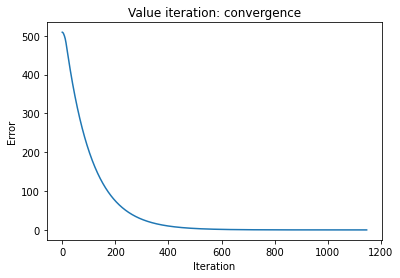

In [9]:
# Comparison of computing time
import time
"""I chose to import the time module to calculate 
the different computation times of the algorithms 
in order to compare them. """


# Parameters
tol = 1e-5
gamma = 0.99

# Environment
env = get_env()

# run value iteration to obtain Q-values
start = time.time()
VI_Q, VI_greedypol, all_qfunctions = value_iteration(env.P, env.R, gamma=gamma, tol=tol)
end = time.time()
VI_time = end - start

# render the policy
print("[VI]Greedy policy: ")
render_policy(env, VI_greedypol)

# compute the value function of the greedy policy using matrix inversion
"""In my code, setting tol to 0 compute the value function 
using matrix inversion"""
greedy_V = policy_evaluation(env.P, env.R, VI_greedypol, gamma, tol = 0)

# show the error between the computed V-functions and the final V-function
# (that should be the optimal one, if correctly implemented)
# as a function of time
final_V = all_qfunctions[-1].max(axis=1)
norms = [ np.linalg.norm(q.max(axis=1) - final_V) for q in all_qfunctions]
plt.plot(norms)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Value iteration: convergence")

#### POLICY ITERATION ####
start = time.time()
PI_policy, PI_V = policy_iteration(env.P, env.R, gamma=gamma, tol=0)
"""I changed the value of tol setting it to 0 
because greedy_V was calculated with a direct computation
so the approximation error is 0 and so by setting tol to 0 
each step of the "policy evaluation" is also with direct computation. """
end = time.time()
PI_time = end - start

print("\n[PI]final policy: ")
render_policy(env, PI_policy)

print("Value Iteration Computing time:", VI_time)
print("Policy Iteration Computing time:", PI_time)


## Uncomment below to check that everything is correct
assert np.allclose(PI_policy, VI_greedypol),\
    "You should check the code, the greedy policy computed by VI is not equal to the solution of PI"
assert np.allclose(PI_V, greedy_V),\
   "Since the policies are equal, even the value function should be"

plt.show()

# Part 2 - Tabular RL

## Question 2.1

The code below collects two datasets of transitions (containing states, actions, rewards and next states) for a discrete MDP.

For each of the datasets:

1. Estimate the transitions and rewards, $\hat{P}$ and $\hat{R}$.
2. Compute the optimal value function and the optimal policy with respect to the estimated MDP (defined by $\hat{P}$ and $\hat{R}$), which we denote by $\hat{\pi}$ and $\hat{V}$.
3. Numerically compare the performance of $\hat{\pi}$ and $\pi^\star$ (the true optimal policy), and the error between $\hat{V}$ and $V^*$ (the true optimal value function).

Which of the two data collection methods do you think is better? Why?

### **Answer**

After several tests, I notice that using dataset 2 to estimate transitions and rewards allows to find a good approximation of the value function **each time**  (around 98-99%) while using dataset 1 gives a bad approximation in $L_{\infty}$- norm. Moreover, when comparing the performance of the optimal policies with respect to the estimated MDPs, I notice that most of the time the policy from dataset 1 does not evolve because it does not find the goal while with the optimal policy from dataset 2 the goal is reached.

The second method of data collection seems more suitable for this type of problem because it allows us to obtain, through a uniform sampling of states and actions, a set of data that seems to take the environment into account in a global way, whereas this is not the case with the first method of data collection, which allows us to obtain a set of data by following a random policy.

In [10]:
def get_random_policy_dataset(env, n_samples):
  """Get a dataset following a random policy to collect data."""
  states = []
  actions = []
  rewards = []
  next_states = []
  
  state = env.reset()
  for _ in range(n_samples):
    action = env.action_space.sample()
    next_state, reward, is_terminal, info = env.step(action)
    states.append(state)
    actions.append(action)
    rewards.append(reward)
    next_states.append(next_state)
    # update state
    state = next_state
    if is_terminal:
      state = env.reset()

  dataset = (states, actions, rewards, next_states)
  return dataset

def get_uniform_dataset(env, n_samples):
  """Get a dataset by uniformly sampling states and actions."""
  states = []
  actions = []
  rewards = []
  next_states = []
  for _ in range(n_samples):
    state = env.observation_space.sample()
    action = env.action_space.sample()
    next_state, reward, is_terminal, info = env.sample(state, action)
    states.append(state)
    actions.append(action)
    rewards.append(reward)
    next_states.append(next_state)

  dataset = (states, actions, rewards, next_states)
  return dataset


# Collect two different datasets
num_samples = 500
env = get_env()
dataset_1 = get_random_policy_dataset(env, num_samples)
dataset_2 = get_uniform_dataset(env, num_samples)


# Item 3: Estimate the MDP with the two datasets; compare the optimal value
# functions in the true and in the estimated MDPs

def N(env, states,actions, rewards, next_states):
  """
    Args:
        env : GridWorld
              environment where to run the policy
        states : list or np.array
               states sampling (num_samples)
        actions : list or np.array
               actions sampling (num_samples)
        rewards : list or np.array
               rewards sampling (num_samples)
        next_states : list or np.array
               next_states sampling (num_samples)
        
    Return:
        Nt : number of occurrences of transitions
        P : empirical transitions
        R : empirical rewards
    """

  Ns = env.Ns
  Na = env.Na
  assert(len(states)==len(actions)==len(rewards)==len(next_states))
  N_sample = len(states)

  # Conversion to arrays for the computation of the empirical reward
  states = np.array(states)
  actions = np.array(actions)
  rewards = np.array(rewards)
  next_states = np.array(next_states)

  P = np.zeros((Ns,Na,Ns))
  R = np.zeros((Ns,Na))
  Nt = np.zeros((Ns,Na,Ns))

  # Initialisation of N(s,a,s')
  for i in range(N_sample):
    Nt[states[i],actions[i],next_states[i]] += 1

  # Computation of N(s,a)
  Nta = np.sum(Nt, axis = 2)

  for s in np.unique(states):
    for a in np.unique(actions):
      for s_n in np.unique(next_states):

        if (Nta[s,a] != 0):
           P[s,a,s_n] = Nt[s,a,s_n]/Nta[s,a]

      r = 0
      for i in range(len(rewards)):
        r += rewards[i]*int(states[i] == s)*int(actions[i] == a)
      
      if (Nta[s,a] != 0):
        R[s,a] = r/Nta[s,a]

  return Nt, P, R

(states1, actions1, rewards1, next_states1) = dataset_1
(states2, actions2, rewards2, next_states2) = dataset_2

_, P1, R1 = N(env, states1, actions1, rewards1, next_states1)
_, P2, R2 = N(env, states2, actions2, rewards2, next_states2)

policy_Est1, V_Est1 = policy_iteration(P1, R1, gamma, 0)
policy_Est2, V_Est2 = policy_iteration(P2, R2, gamma, 0)
policy_True, V_True = policy_iteration(env.P, env.R, gamma, 0)


 Policy iteration converges in 1 iterations

 Policy iteration converges in 14 iterations

 Policy iteration converges in 5 iterations


In [11]:
# Comparison table
import pandas as pd
data = pd.DataFrame(index = ['Difference of P', 'Difference of R',
                             'Value function error'], 
                    columns = ['Dataset 1','Dataset 2'])
data['Dataset 1'] = [np.sum(abs(P1-env.P)), np.sum(abs(R1-env.R)), 
                     max(abs(V_Est1 - V_True))]
data['Dataset 2'] = [np.sum(abs(P2-env.P)),np.sum(abs(R2-env.R)),
                     max(abs(V_Est2 - V_True))]

data

,Dataset 1,Dataset 2
Difference of P,34.450716,29.638095
Difference of R,3.000000,0.000000
Value function error,100.000000,1.078724


In [12]:
# Performance of policies
print("\n[PI]True optimal policy: ")
render_policy(env, policy_True)
print("\n[PI]Policy estimated with dataset 1: ")
render_policy(env, policy_Est1)
print("\n[PI]Policy estimated with dataset 2: ")
render_policy(env, policy_Est2)


[PI]True optimal policy: 



[PI]Policy estimated with dataset 1: 



[PI]Policy estimated with dataset 2: 


## Question 2.2

Suppose that $\hat{P}$ and $\hat{R}$ are estimated from a dataset of exactly $N$ i.i.d. samples from **each** state-action pair. This means that, for each $(s,a)$, we have $N$ samples $\{(s_1',r_1, \dots, s_N', r_N\}$, where $s_i' \sim P(\cdot | s,a)$ and $r_i \sim R(s,a)$ for $i=1,\dots,N$, and
$$ \hat{P}(s'|s,a) = \frac{1}{N}\sum_{i=1}^N \mathbb{1}(s_i' = s'), $$
$$ \hat{R}(s,a) = \frac{1}{N}\sum_{i=1}^N r_i.$$
Suppose that $R$ is a distribution with support in $[0,1]$. Let $\hat{V}$ be the optimal value function computed in the empirical MDP (i.e., the one with transitions $\hat{P}$ and rewards $\hat{R}$). For any $\delta\in(0,1)$, derive an upper bound to the error

$$ \| \hat{V} - V^* \|_\infty $$

which holds with probability at least $1-\delta$.

**Note** Your bound should only depend on deterministic quantities like $N$, $\gamma$, $\delta$, $S$, $A$. It should *not* dependent on the actual random samples.

**Hint** The following two inequalities may be helpful.

1. **A (simplified) simulation lemma**. For any state $\bar{s}$,

$$ |\hat{V}(\bar{s}) - V^*(\bar{s})| \leq \frac{1}{1-\gamma}\max_{s,a} \left| R(s,a) - \hat{R}(s,a) + \gamma \sum_{s'}(P(s'|s,a) - \hat{P}(s'|s,a)) V^*(s') \right|$$

2. **Hoeffding's inequality**. Let $X_1, \dots X_N$ be $N$ i.i.d. random variables bounded in the interval $[0,b]$ for some $b>0$. Let $\bar{X} = \frac{1}{N}\sum_{i=1}^N X_i$ be the empirical mean. Then, for any $\epsilon > 0$,

$$ \mathbb{P}(|\bar{X} - \mathbb{E}[\bar{X}]| > \epsilon) \leq 2e^{-\frac{2N\epsilon^2}{b^2}}.$$

### **Answer**

For any state $\bar{s}$,

$|\hat{V}(\bar{s}) - V^*(\bar{s})| \leq \frac{1}{1-\gamma}\max_{s,a} \left| R(s,a) - \hat{R}(s,a) + \gamma \sum_{s'}(P(s'|s,a) - \hat{P}(s'|s,a)) V^*(s') \right|$ 

$\\ \qquad \qquad \quad \ \leq  \frac{1}{1-\gamma}\max_{s,a} \left| R(s,a) - \hat{R}(s,a) \right| + \frac{\gamma}{1-\gamma}\max_{s,a} \sum_{s'} \left|(P(s'|s,a) - \hat{P}(s'|s,a)) V^*(s') \right|$

If, we have :

$$|\hat{V}(\bar{s}) - V^*(\bar{s})| > \epsilon \quad \text{necessairly} \quad $$
$$\frac{1}{1-\gamma}\max_{s,a} \left| R(s,a) - \hat{R}(s,a) \right| > \frac{\epsilon}{2} \quad or \quad \frac{\gamma}{1-\gamma}\max_{s,a} \sum_{s'} \left| (P(s'|s,a) - \hat{P}(s'|s,a)) V^*(s') \right| > \frac{\epsilon}{2} \qquad \textbf{(*)}$$ 

Then, 

$\mathbb{P}(|\hat{V}(\bar{s}) - V^*(\bar{s})| > \epsilon) \leq \mathbb{P}(\frac{1}{1-\gamma}\max_{s,a} \left| R(s,a) - \hat{R}(s,a) \right| > \frac{\epsilon}{2}) + \mathbb{P}(\frac{\gamma}{1-\gamma}\max_{s,a} \sum_{s'} \left| (P(s'|s,a) - \hat{P}(s'|s,a)) V^*(s') \right| > \frac{\epsilon}{2})$ 
$\\ \qquad \qquad \qquad \ \leq \mathbb{P}(\cup_{s \in S, a \in A} \{ \left| R(s,a) - \hat{R}(s,a) \right| > \frac{\epsilon.(1-\gamma)}{2} \}) + \mathbb{P}(\cup_{s \in S, a \in A} \{ \sum_{s'} \left| (P(s'|s,a) - \hat{P}(s'|s,a)) V^*(s') \right| > \frac{\epsilon.(1-\gamma)}{2.\gamma} \})$ 
$\\ \qquad \qquad \qquad \ \leq \sum_{s \in S, a \in A}\mathbb{P}( \left| R(s,a) - \hat{R}(s,a) \right| > \frac{\epsilon.(1-\gamma)}{2} ) + \sum_{s \in S, a \in A} \mathbb{P}(\sum_{s'} \left| (P(s'|s,a) - \hat{P}(s'|s,a)) V^*(s') \right| > \frac{\epsilon.(1-\gamma)}{2.\gamma})$ 


$\hat{P}$ and $\hat{R}$ are estimated from a dataset of exactly $N$ i.i.d. samples from **each** state-action pair.

$r_1, ..., r_N$ are i.i.d random variables bounded in the interval $[0,1]$. $R(s,a)$ denotes both the distribution and the mean value of the reward distribution in $(s,a)$
and $\hat{R}(s,a)$ is the empirical mean. Then, for any $\epsilon > 0$, the Hoeffding's inequality gives us : 

$$\boxed{\mathbb{P} \left(| R(s,a) - \hat{R}(s,a)| > \frac{\epsilon.(1-\gamma)}{2} \right) \leq 2e^{\frac{-2N(\frac{\epsilon.(1-\gamma)}{2})^2}{1^2}} = 2e^{\frac{-N.\epsilon^2.(1-\gamma)^2}{2}}}$$



<br>

Moreover,
<br>
We have that : for all policy $\pi$ and for all  $s \in S$, as $\gamma \geq 0$ and $R$ is a distribution with support in $[0,1]$  


$0 \leq V^{\pi}(s) = \mathbb{E}[\sum_{t = 0}^{\infty} \gamma^{t}.R(s_t,d_t(s_t)) \ \vert s_0=s \ ; \pi \ ]  \leq \mathbb{E}[\sum_{t = 0}^{\infty} \gamma^{t}.1 \ \vert s_0=s \ ; \pi \ ] \leq  \frac{1}{1-\gamma}$

Then, $$\boxed{0 \leq V^{*}(s) \leq \frac{1}{1-\gamma}}$$



<br> 

With the same idea in (*)

<br>

$$\mathbb{P}\left(\sum_{s'} \left| (P(s'|s,a) - \hat{P}(s'|s,a)).V^*(s'))\right| > \frac{\epsilon.(1-\gamma)}{2.\gamma}\right) \leq  \sum_{s'} \mathbb{P}\left( \left| P(s'|s,a) - \hat{P}(s'|s,a)).V^*(s')\right| > \frac{\epsilon.(1-\gamma)}{2.\gamma.|S|}\right)$$

Let $s$ be in $S$ and $a$ in $A$. Let $s'$ in $S$.

From the assumption, $s_1, ..., s_N$ are i.i.d random variables then $\mathbb{1}(s_i' = s').V^{*}(s')$ are also i.i.d random variables bounded in the interval $[0,\frac{1}{1-\gamma}]$ and with expectation $\mathbb{E}[\mathbb{1}(s_i' = s').V^{*}(s')] = P(s'|s,a).V^{*}(s')$


Then, for any $\epsilon > 0$, the Hoeffding's inequality gives us : 
$$\mathbb{P}\left(\left|\hat{P}(s'|s,a).V^*(s') - P(s'|s,a).V^*(s')\right| > \frac{\epsilon.(1-\gamma)}{2.\gamma.|S|}\right) \leq 2e^{-\frac{2N.\left(\frac{\epsilon.(1-\gamma)}{2.\gamma.|S|}\right)^2}{(\frac{1}{1-\gamma})^2}} = 2e^{\frac{-N. \epsilon^2 * ({1- \gamma})^4}{2.\gamma^2.|S|^2}}$$

Then, 
$$\boxed{\mathbb{P}(\sum_{s'} \left| (P(s'|s,a) - \hat{P}(s'|s,a)).
 V^*(s'))\right| > \frac{\epsilon}{2}) \leq 
 2.|S|e^{\frac{-N. \epsilon^2 * ({1- \gamma})^4}{2.\gamma^2.|S|^2}}}$$


<br>

Finally, 

$$\mathbb{P}(|\hat{V}(\bar{s}) - V^*(\bar{s})| > \epsilon) \leq |S|.|A|.\left(2.e^{\frac{-N.\epsilon^2.(1-\gamma)^2}{2}} + 2.|S|e^{\frac{-N. \epsilon^2 * ({1- \gamma})^4}{2.\gamma^2.|S|^2}}\right) 
\leq 4.|S|.|A|.max(e^{\frac{-N.\epsilon^2.(1-\gamma)^2}{2}},|S|e^{\frac{-N. \epsilon^2 * ({1- \gamma})^4}{2.\gamma^2.|S|^2}})$$

<br>
with $\boxed{\epsilon(N,\gamma,\delta,S,A) = max\left(\sqrt{\frac{2}{N.(1-\gamma)^2}.log(\frac{4.|S|.|A|}{\delta})},\sqrt{\frac{2.\gamma^2.|S|^2}{N.(1-\gamma)^4}.log(\frac{4.|S|^2.|A|}{\delta})}\right)}$.  (less restrictive than the min)

$$\mathbb{P}\left(|\hat{V}(\bar{s}) - V^*(\bar{s})| > \epsilon(N,\gamma,\delta,S,A)\right) \leq \delta$$

Finally, 

$$\boxed{\| \hat{V} - V^* \|_\infty < \epsilon(N,\gamma,\delta,S,A)} \text{ with probability at least } 1-\delta.$$

Here, what is important is that with $\delta$  close enough to 0 one has quite favorably (i.e. with probability at least $1-\delta$) that the approximation error is in $O(\frac{1}{\sqrt{N}})$.

## Question 2.3

Suppose once again that we are given a dataset of $N$ samples in the form of tuples $(s_i,a_i,s_i',r_i)$. We know that each tuple contains a valid transition from the true MDP, i.e., $s_i' \sim P(\cdot | s_i, a_i)$ and $r_i \sim R(s_i,a_i)$, while the state-action pairs $(s_i,a_i)$ from which the transition started can be arbitrary.

Suppose we want to apply Q-learning to this MDP. Can you think of a way to leverage this offline data to improve the sample-efficiency of the algorithm? What if we were using SARSA instead?

### **Answer**

### Q-Learning

Q-learning is a model-free reinforcement learning algorithm that seeks to find the best action to take given the current state. A way to leverage this offline data to improve the sample-efficiency of the algorithm is to take integrating a world model and to use planning. **I suggest to use Dyna-Q learning** which includes all of the following processes: planning, action, model learning and direct RL, all of which occur continuously.


### Sarsa

Sarsa is on-policy and it updates its Q-values using the Q-value of the next state and the action of the current policy. Here, the update of Q is based on the sample of the dataset and it is necessairly off-policy.
In this case, **SARSA** would not work.

# Part 3 - RL with Function Approximation

## Question 3.1

Given a datset $(s_i, a_i, r_i, s_i')$ of (states, actions, rewards, next states), the Fitted Q-Iteration (FQI) algorithm proceeds as follows:


* We start from a $Q$ function $Q_0 \in \mathcal{F}$, where $\mathcal{F}$ is a function space;
* At every iteration $k$, we compute $Q_{k+1}$ as:

$$
Q_{k+1}\in\arg\min_{f\in\mathcal{F}} \frac{1}{2}\sum_{i=1}^N
\left(
  f(s_i, a_i) - y_i^k
\right)^2 + \lambda \Omega(f)
$$
where $y_i^k = r_i + \gamma \max_{a'}Q_k(s_i', a')$, $\Omega(f)$ is a regularization term and $\lambda > 0$ is the regularization coefficient.


Consider FQI with *linear* function approximation. That is, for a given feature map $\phi : S \rightarrow \mathbb{R}^d$, we consider a parametric family of $Q$ functions $Q_\theta(s,a) = \phi(s)^T\theta_a$ for $\theta_a\in\mathbb{R}^d$. Suppose we are applying FQI on a given dataset of $N$ tuples of the form $(s_i, a_i, r_i, s_i')$ and we are at the $k$-th iteration. Let $\theta_k \in\mathbb{R}^{d \times A}$ be our current parameter. Derive the *closed-form* update to find $\theta_{k+1}$, using $\frac{1}{2}\sum_a ||\theta_a||_2^2$ as regularization.

### **Answer**

We consider a parametric family of $Q$ functions $Q_\theta(s,a) = \phi(s)^T\theta_a = \phi(s)^T\theta E_a$ with $E_a = (\delta_{ia})_{1 \leq i \leq A}$
in $\mathbb{R}^A$. Suppose we are applying FQI on a given dataset of $N$ tuples of the form $(s_i, a_i, r_i, s_i')$ and we are at the $k$-th iteration. Let $\theta_k \in\mathbb{R}^{d \times A}$ be our current parameter. We use $\frac{1}{2}\sum_a ||\theta_a||_2^2$ as regularization.
We want to find one minimizer of : 
$$ f : \theta \mapsto \frac{1}{2}\sum_{i=1}^N \left(\phi(s_i)^T\theta E_{a_i} - y_i^k \right)^2 + \frac{\lambda}{2}\sum_{a \in A} ||\theta_a||_2^2$$

By noticing that : 
$||\theta_a||_2^2 = \theta_a^{T}.\theta_a = E_{a}^{T}\theta^{T}.\theta E_a$ 

The considered function is thus convex and coercive. There is then at least one minimizer and the gradient at this point (and all the other minimizers) is zero.


I will use the following equations : 
$$\frac{\partial (a^{T}X^{T}CXb)}{\partial X} = C^{T}Xab^{T} + CXba^{T}$$

$$\frac{\partial (a^{T}Xb)}{\partial X} = ab^{T}$$

By deriving, I then obtain:

$\nabla f(\theta) = \sum_{i=1}^N \frac{\partial (\phi(s_i)^T\theta E_{a_i})}{\partial \theta} \left(\phi(s_i)^T\theta E_{a_i} - y_i^k \right) + \lambda \sum_{a \in A} \theta E_a.E_{a}^{T} = \sum_{i=1}^N \phi(s_i)E_{a_i}^T \left(\phi(s_i)^T\theta E_{a_i} - y_i^k \right) + \lambda \theta \sum_{a \in A}  E_{aa}  \\ $ 
$\boxed{\nabla f(\theta)  = \sum_{i=1}^N \phi(s_i)E_{a_i}^T \left(\phi(s_i)^T\theta E_{a_i} - y_i^k \right) + \lambda \theta} \qquad \text{because} \, \sum_{a \in A}  E_{aa} = I_A$

<br>

If we want $\theta_{k+1}$ to be a minimizer, then it must satisfy : 
$\quad \sum_{i=1}^N \phi(s_i)E_{a_i}^T \left(\phi(s_i)^T\theta_{k+1} E_{a_i} - y_i^k \right) + \lambda \theta_{k+1} = 0$ 

i.e $$\lambda \theta_{k+1} + \sum_{i=1}^N \phi(s_i)E_{a_i}^T \phi(s_i)^T\theta_{k+1} E_{a_i} = \sum_{i=1}^N y_i^k \phi(s_i)E_{a_i}^T$$

<br>

Multiplying by $E_a$, it follows : 

$\qquad \ \ \  \lambda (\theta_{k+1})_a+ \sum_{i=1}^N \left(\phi(s_i)^T\theta_{k+1} E_{a_i}\right)\phi(s_i)E_{a_i}^T E_a = \sum_{i=1}^N y_i^k \phi(s_i)E_{a_i}^T E_a \\$ 

$\Leftrightarrow \lambda (\theta_{k+1})_a+ \sum_{i=1}^N \left(\phi(s_i)^T(\theta_{k+1})_{a_i}\right)\phi(s_i)\mathbb{1}_{\{a_i = a\}} = \sum_{i=1}^N y_i^k \phi(s_i) \mathbb{1}_{\{a_i = a\}} \qquad$ (*) 

$\Leftrightarrow \lambda (\theta_{k+1})_a+ \sum_{i=1}^N \mathbb{1}_{\{a_i = a\}}\phi(s_i)\left(\phi(s_i)^T(\theta_{k+1})_{a}\right) = \sum_{i=1}^N \mathbb{1}_{\{a_i = a\}} y_i^k \phi(s_i) \qquad$ (*) 

$\Leftrightarrow \left(\lambda I_d + \sum_{i=1}^N \mathbb{1}_{\{a_i = a\}}\phi(s_i)\phi(s_i)^T\right)(\theta_{k+1})_{a} = \sum_{i=1}^N \mathbb{1}_{\{a_i = a\}} y_i^k \phi(s_i)$


(*) I use the fact that if $X \in \mathbb{R}^d$ and $\mu \in \mathbb{R}$, then $\mu.X = X.\mu$ 

Since $\left(\lambda I_d + \sum_{i=1}^N \mathbb{1}_{\{a_i = a\}}\phi(s_i)\phi(s_i)^T\right)$ is invertible except for a finite number of values of $\lambda$, I obtain this:  
$$\boxed{(\theta_{k+1})_{a} = \left(\lambda I_d + \sum_{i=1}^N \mathbb{1}_{\{a_i = a\}}\phi(s_i)\phi(s_i)^T\right)^{-1}\sum_{i=1}^N \mathbb{1}_{\{a_i = a\}} y_i^k \phi(s_i)}$$ 


## Question 3.2

The code below creates a larger gridworld (with more states than the one used in the previous questions), and defines a feature map. Implement linear FQI to this environment (in the function `linear_fqi()` below), and compare the approximated $Q$ function to the optimal $Q$ function computed with value iteration.

Can you improve the feature map in order to reduce the approximation error?

### **Answer**

I used the dataset by uniformly sampling the states and actions, which leads to better results. For a fixed number of samples, **increasing the  feature dimension** and **decreasing the bandwidth** of the RBF kernel through which the feature map is established leads to better results.

I used also other feature maps by replacing the similarity matrix by :  
- dist : goal reached in about 7 seconds even with smaller dimensions (∼ 100) and without considering the "sigma" parameter.
- (abs(x_jj - x_ii)<5)* (abs(y_jj - y_ii)<5) : not good

In [13]:
def get_large_gridworld():
  """Creates an instance of a grid-world MDP with more states."""
  walls = [(ii, 10) for ii in range(15) if (ii != 7 and ii != 8)]
  env = GridWorld(
      nrows=15,
      ncols=15,
      reward_at = {(14, 14):1.0},
      walls=tuple(walls),
      success_probability=0.9,
      terminal_states=((14, 14),)
  )
  return env


class GridWorldFeatureMap:
  """Create features for state-action pairs
  
  Args:
    dim: int
      Feature dimension
    sigma: float
      RBF kernel bandwidth
  """
  def __init__(self, env, dim=15, sigma=0.25):
    self.index2coord = env.index2coord
    self.n_states = env.Ns
    self.n_actions = env.Na
    self.dim = dim
    self.sigma = sigma

    n_rows = env.nrows
    n_cols = env.ncols

    # build similarity matrix
    sim_matrix = np.zeros((self.n_states, self.n_states))
    for ii in range(self.n_states):
        row_ii, col_ii = self.index2coord[ii]
        x_ii = row_ii / n_rows
        y_ii = col_ii / n_cols
        for jj in range(self.n_states):
            row_jj, col_jj = self.index2coord[jj]
            x_jj = row_jj / n_rows
            y_jj = col_jj / n_cols
            dist = np.sqrt((x_jj - x_ii) ** 2.0 + (y_jj - y_ii) ** 2.0)
            sim_matrix[ii, jj] = np.exp(-(dist / sigma) ** 2.0)
            
            """ Test of other feature maps """
            #sim_matrix[ii, jj] = dist
            #sim_matrix[ii, jj] = (abs(x_jj - x_ii)<5)*(abs(y_jj - y_ii)<5)


    # factorize similarity matrix to obtain features
    uu, ss, vh = np.linalg.svd(sim_matrix, hermitian=True)
    self.feats = vh[:dim, :]

  def map(self, observation):
    feat = self.feats[:, observation].copy()
    return feat

In [14]:
env = get_large_gridworld()
feat_map = GridWorldFeatureMap(env)

# Visualize large gridworld
render_policy(env)

# The features have dimension (feature_dim).
feature_example = feat_map.map(1) # feature representation of s=1
print(feature_example)

# Initial vector theta representing the Q function
theta = np.zeros((feat_map.dim, env.action_space.n))
print(theta.shape)
print(feature_example @ theta) # approximation of Q(s=1, a)

[-0.02850699  0.063555   -0.02169407 -0.06441918  0.04505794 -0.07537777
  0.08506473 -0.09325287  0.09644275 -0.00535101  0.11632395 -0.13074085
  0.00921342 -0.13853662  0.07118419]
(15, 4)
[0. 0. 0. 0.]


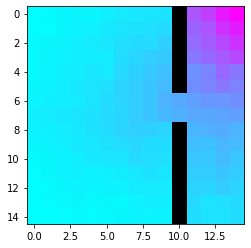

In [15]:
def linear_fqi(env, feat_map, num_iterations, lambd=0.1, gamma=0.95):
  """
  Args:
    env: GridWorld
        environment where to run the policy
    feat_map: np.array
        feature map
    num_iterations: int
        number of iterations 
    lambd: float
        regularization coefficient
    gamma: float
        discount factor
  """

  # get a dataset
  #    dataset = get_uniform_dataset(env, n_samples=...)
  # OR dataset = get_random_policy_dataset(env, n_samples=...)
  
  theta = np.zeros((feat_map.dim, env.Na))
  
  # get a dataset of 1000 samples
  (states, actions, rewards, next_states) = get_uniform_dataset(env, n_samples = 2000) 
  A = np.unique(actions)
  for it in range(num_iterations):
    
    Q = feat_map.map(next_states).T @ theta
    Y = rewards + gamma * np.max(Q, axis = 1)

    for a in A :  
     indic = np.array((actions == a), dtype = int)
     intermediate = lambd * np.eye(feat_map.dim) + (feat_map.map(states) * indic)@feat_map.map(states).T 

     theta[:,a]  = np.linalg.inv(intermediate) @ (feat_map.map(states)@(Y * indic)).T 
  return theta

# ----------------------------
# Environment and feature map
# ----------------------------
env = get_large_gridworld()
# you can change the parameters of the feature map, and even try other maps!
feat_map = GridWorldFeatureMap(env, dim=200, sigma=0.10)

# -------
# Run FQI
# -------
theta = linear_fqi(env, feat_map, num_iterations=100)

# Compute and run greedy policy
Q_fqi = np.zeros((env.Ns, env.Na))
for ss in range(env.Ns):
  state_feat = feat_map.map(ss)
  Q_fqi[ss, :] = state_feat @ theta

V_fqi = Q_fqi.max(axis=1)
policy_fqi = Q_fqi.argmax(axis=1)
render_policy(env, policy_fqi, horizon=100)

# Visualize the approximate value function in the gridworld.
img = env.get_layout_img(V_fqi)    
plt.imshow(img)
plt.show()